In [ ]:
%matplotlib inline
import os

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn. functional as F

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.utils import save_image

import cv2
from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from utils.visualize import visualize, reverse_normalize

In [ ]:
device = torch.device('cuda:0')

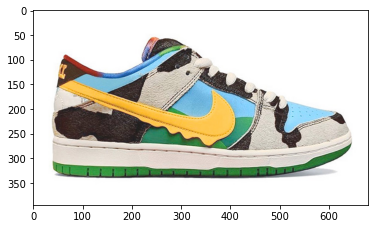

In [3]:
test_image = Image.open('ben_jerry_dunks.jpg')
imshow(test_image)

In [ ]:
# normalize image and convert to pytorch tensors
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [ ]:
tensor = preprocess(test_image)
tensor = tensor.unsqueeze(0)

In [6]:
# grab vgg model
model_name = 'VGG.pt'
model = torch.load(model_name)
model.eval()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Visualizing last conv layer applying to image

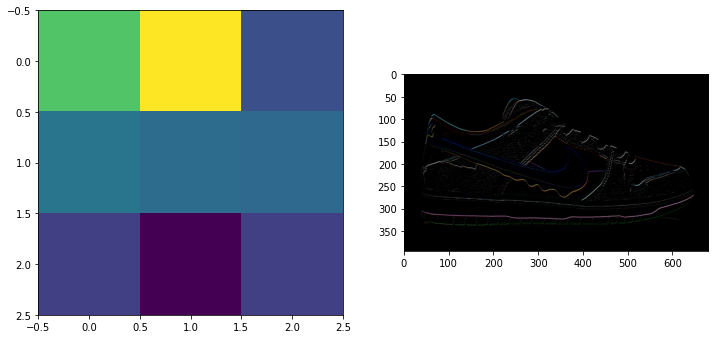

In [20]:
weights = model.features[0].weight.data.cpu().numpy()
test_np = np.asarray(test_image)
# change this here to visualize different filters
filter = 9

# visualize effects of convolutional filters on image
plt.figure(figsize=(12,15))
plt.subplot(1, 2, 1)
imshow(weights[int((filter-1)/2)][0])
plt.subplot(1, 2, 2)
imshow(cv2.filter2D(test_np, -1, weights[int((filter-1)/2)][0]))

# channels = 64
# x = 16*2
# y = 16*2
# fig=plt.figure(figsize=(450,450))
# for i in range(channels):
#   fig.add_subplot(x, y, i+1)
#   if i%2:
#     filtered = cv2.filter2D(test_np, -1, weights[int((i-1)/2)][0])
#     imshow(brightened)
#   else:
#     imshow(weights[int((i-1)/2)][0])

### Score-Cam
This part of the notebook is based on Score-Cam implementation by yiskw713<br />
https://github.com/yiskw713/ScoreCAM

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


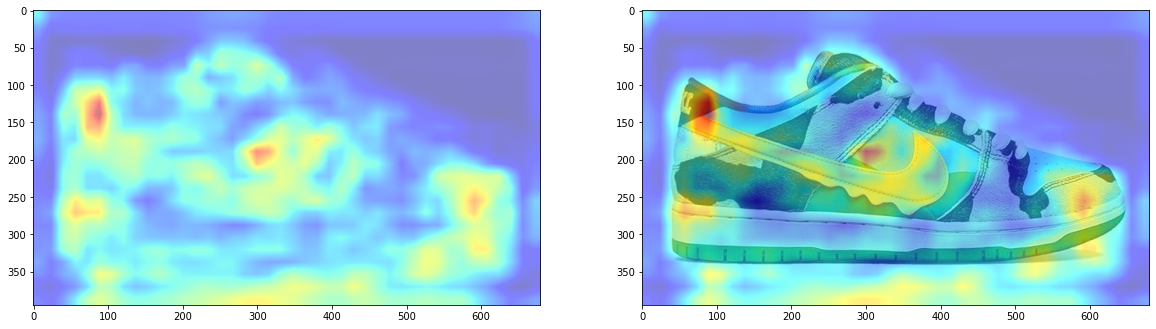

In [41]:
# score and grad cam on convolutional layers
target_layer = model.features[28] #last conv layer
wrapped_model = ScoreCAM(model, target_layer)
cam, _ = wrapped_model(tensor.to(device))
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
imshow(cam.squeeze().cpu().numpy(), alpha=0.5, cmap='jet')
heatmap = visualize(img, cam.cpu())
plt.subplot(1, 2, 2)
imshow(heatmap.squeeze().cpu().numpy().transpose(1, 2, 0))

predicted class ids 2	 probability 0.9121268391609192


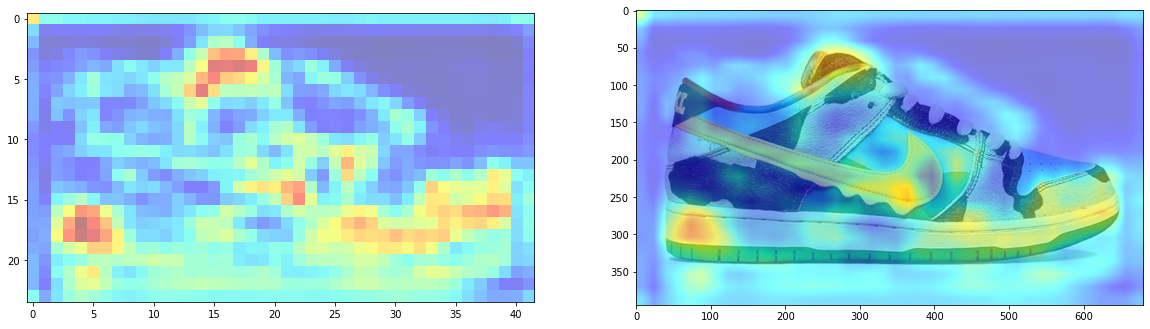

In [40]:
wrapped_model = SmoothGradCAMpp(model, target_layer)
cam, _ = wrapped_model(tensor.to(device))
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
imshow(cam.squeeze().cpu().numpy(), alpha=0.5, cmap='jet')
heatmap = visualize(img, cam.cpu())
plt.subplot(1, 2, 2)
imshow(heatmap.squeeze().cpu().numpy().transpose(1, 2, 0))